### 1. Importing packages

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### 2. Loading datasets

In [ ]:
Xy_train = pd.read_csv('train.csv', index_col=0)

# splitting features and response in train dataset
y_train = np.log(Xy_train['SalePrice'])
X_train = Xy_train.drop('SalePrice', axis=1)

X_test = pd.read_csv('test.csv', index_col=0)

# combining train and test features
X_combined0 = pd.concat([X_train, X_test], axis=0)
X_combined0.shape

(2919, 79)

### 3. Feature engineering

In [ ]:
# removing columns with missing values more than 20%
X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2

cols = [col for col in X_combined0.columns if X_null[col] <= max_na]
X_combined1 = X_combined0[cols]
X_combined1.shape

(2919, 74)

In [ ]:
X_combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

In [ ]:
# getting no. of cardinal (numeric) columns, categorical columns and ordinal columns
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_combined1.select_dtypes(include='object').columns.tolist()

grade_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
              'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ord_cols = []
for col in grade_cols:
    if col in cat_cols:
        cat_cols.remove(col)
        ord_cols.append(col)

print(f'Cardinal columns = {len(num_cols)}')
print(f'Categorical columns = {len(cat_cols)}')
print(f'Ordinal columns = {len(ord_cols)}')

Cardinal columns = 36
Categorical columns = 30
Ordinal columns = 8


In [ ]:
# imputing cardinal columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

# imputing categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_combined2[cat_cols] = cat_imputer.fit_transform(X_combined1[cat_cols])

# imputing ordinal columns
ord2int_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:np.nan}
for col in ord_cols:
    X_combined2[col] = X_combined2[col].map(ord2int_map)

ord_imputer = SimpleImputer(strategy='mean')
X_combined3 = X_combined2.copy()
X_combined3[ord_cols] = ord_imputer.fit_transform(X_combined2[ord_cols])

In [ ]:
# adding interaction column
X_combined3['GrLivArea * OverallQual'] = X_combined3['GrLivArea'] * X_combined3['OverallQual']

In [ ]:
X_combined3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 75 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               2919 non-null   float64
 1   MSZoning                 2919 non-null   object 
 2   LotFrontage              2919 non-null   float64
 3   LotArea                  2919 non-null   float64
 4   Street                   2919 non-null   object 
 5   LotShape                 2919 non-null   object 
 6   LandContour              2919 non-null   object 
 7   Utilities                2919 non-null   object 
 8   LotConfig                2919 non-null   object 
 9   LandSlope                2919 non-null   object 
 10  Neighborhood             2919 non-null   object 
 11  Condition1               2919 non-null   object 
 12  Condition2               2919 non-null   object 
 13  BldgType                 2919 non-null   object 
 14  HouseStyle              

In [ ]:
# one hot encoding categorical columns
X_combined4 = pd.get_dummies(X_combined3)

### 4. Performance evaluation

In [ ]:
# function for performance evaluation
def model_perf(model, X, y, prefix=''):
    y_hat = model.predict(X)
    r2 = r2_score(y, y_hat)
    rmsle = mean_squared_log_error(y, y_hat, squared=False)
    print(f'{prefix} R^2 score = {r2:.3f}, RMSLE = {rmsle:.3f}')

# function for fitting and evaluating model
def model_fit_eval(model, X_all, y_all, prefix=''):
    X_trn, X_val, y_trn, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
    model.fit(X_trn, y_trn)
    print(prefix)
    model_perf(model, X_trn, y_trn, '  Training   ')
    model_perf(model, X_val, y_val, '  Validation ')
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_score = cross_val_score(model, X_all, y_all, cv=kfold)
    print(f'  Cross val. R^2 score mean = {cv_score.mean():.3f}, std = {cv_score.std():.3f}')

### 5. Model selection

In [ ]:
# function to split combined dataset into train and test
def split_train_test(X_combined, n):
    X_train = X_combined.iloc[:n,:]
    X_test = X_combined.iloc[n:,:]
    return X_train, X_test

In [ ]:
X_train, X_test = split_train_test(X_combined4, X_train.shape[0])

In [ ]:
# creating models
r = Ridge()
b = BaggingRegressor(n_estimators=50)
rf = RandomForestRegressor(n_estimators=50)
xgb = XGBRegressor(max_depth=5, objective='reg:squarederror')
lgbm = LGBMRegressor()

estms = [('r', r), ('b', b), ('rf', rf), ('xgb', xgb), ('lgbm', lgbm)]
v = VotingRegressor(estimators=estms, n_jobs=-1) # using all processors
s = StackingRegressor(estimators=estms, final_estimator=Ridge(), n_jobs=-1) # using all processors

In [ ]:
# fitting and evaluating models
models = ['Ridge', 'Bagging', 'Random Forest', 'XGBoost', 'LGBM', 'Voting', 'Stacking']
model_fit_eval(r, X_train, y_train, models[0])
model_fit_eval(b, X_train, y_train, models[1])
model_fit_eval(rf, X_train, y_train, models[2])
model_fit_eval(xgb, X_train, y_train, models[3])
model_fit_eval(lgbm, X_train, y_train, models[4])
model_fit_eval(v, X_train, y_train, models[5])
model_fit_eval(s, X_train, y_train, models[6])
# best model voting (best combined Val R^2 score, RMSLE and Cross val. R^2 score mean)

Ridge
  Training    R^2 score = 0.946, RMSLE = 0.007
  Validation  R^2 score = 0.767, RMSLE = 0.014
  Cross val. R^2 score mean = 0.868, std = 0.053
Bagging
  Training    R^2 score = 0.983, RMSLE = 0.004
  Validation  R^2 score = 0.864, RMSLE = 0.011
  Cross val. R^2 score mean = 0.875, std = 0.016
Random Forest
  Training    R^2 score = 0.982, RMSLE = 0.004
  Validation  R^2 score = 0.876, RMSLE = 0.010
  Cross val. R^2 score mean = 0.876, std = 0.019
XGBoost
  Training    R^2 score = 0.982, RMSLE = 0.004
  Validation  R^2 score = 0.881, RMSLE = 0.010
  Cross val. R^2 score mean = 0.898, std = 0.015
LGBM
  Training    R^2 score = 0.988, RMSLE = 0.003
  Validation  R^2 score = 0.876, RMSLE = 0.011
  Cross val. R^2 score mean = 0.890, std = 0.020
Voting
  Training    R^2 score = 0.983, RMSLE = 0.004
  Validation  R^2 score = 0.881, RMSLE = 0.010
  Cross val. R^2 score mean = 0.900, std = 0.020
Stacking
  Training    R^2 score = 0.976, RMSLE = 0.005
  Validation  R^2 score = 0.867, RMSLE

### 6. Prediction

In [ ]:
# predicting responses for test dataset
sale_price_pred = np.exp(v.predict(X_test))

sub_df = pd.read_csv('sample_submission.csv', index_col=0)
sub_df['SalePrice'] = sale_price_pred

sub_df.to_csv('sub-house-prices.csv')

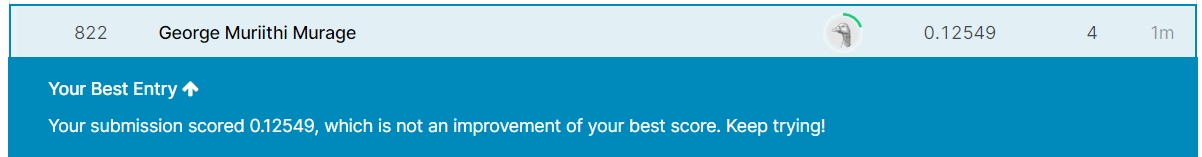